# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [82]:
%matplotlib inline

from time import time
import warnings
from itertools import product
import os
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [4]:
DATA_DIR = Path('..', 'data')

In [5]:
prices = (pd.read_hdf(DATA_DIR / 'stooq/daily.h5', 'jp/tse/stocks/prices')
          .loc[idx[:, '2014': '2019'], :])

In [6]:
prices.info(null_counts=True)    

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4848870 entries, (1301.JP, 2014-01-06 00:00:00) to (9997.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      4848870 non-null float64
high      4848870 non-null float64
low       4848870 non-null float64
close     4848870 non-null float64
volume    4848870 non-null int64
dtypes: float64(4), int64(1)
memory usage: 203.5+ MB


In [7]:
before = len(prices.index.get_level_values('symbol').unique())

### Remove symbols with missing values

In [8]:
prices = (prices.unstack('symbol')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('symbol')
        .swaplevel())
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4198624 entries, (1301.JP, 2014-01-06 00:00:00) to (9997.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      4198624 non-null float64
high      4198624 non-null float64
low       4198624 non-null float64
close     4198624 non-null float64
volume    4198624 non-null float64
dtypes: float64(5)
memory usage: 176.2+ MB


In [9]:
after = len(prices.index.get_level_values('symbol').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,706 after: 2,864


### Keep most traded symbols

In [10]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('symbol').median().nlargest(1000).index.tolist()

In [11]:
prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1466000 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      1466000 non-null float64
high      1466000 non-null float64
low       1466000 non-null float64
close     1466000 non-null float64
volume    1466000 non-null float64
dtypes: float64(5)
memory usage: 61.6+ MB


## Feature Engineering

### Compute period returns

In [12]:
intervals = [1, 5, 10, 21, 63]

In [13]:
returns = []
by_sym = prices.groupby(level='symbol').close
for t in intervals:
    returns.append(by_sym.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [14]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1466000 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
ret_1     1465000 non-null float64
ret_5     1461000 non-null float64
ret_10    1456000 non-null float64
ret_21    1445000 non-null float64
ret_63    1403000 non-null float64
dtypes: float64(5)
memory usage: 61.6+ MB


### Remove outliers

In [15]:
max_ret_by_sym = returns.groupby(level='symbol').max()

In [16]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.145681,0.268016,0.342887,0.453197,0.699203
std,0.061561,0.209205,0.314211,0.545314,0.822495
min,0.057599,0.081609,0.113061,0.146788,0.192217
50%,0.128268,0.206363,0.254089,0.332171,0.493913
90%,0.226131,0.444332,0.537989,0.675574,1.047346
95%,0.264922,0.659088,0.818955,0.997903,1.697734
97.5%,0.299717,0.875280,1.246553,1.608270,2.842420
99%,0.352163,1.261150,1.984029,2.520177,4.736208
99.5%,0.388679,1.439047,2.400568,3.625636,5.720549


In [17]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [18]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

60

In [19]:
prices = prices.drop(to_drop, level='symbol')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      1378040 non-null float64
high      1378040 non-null float64
low       1378040 non-null float64
close     1378040 non-null float64
volume    1378040 non-null float64
dtypes: float64(5)
memory usage: 57.9+ MB


### Calculate relative return percentiles

In [43]:
returns = []
by_sym = prices.groupby(level='symbol').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [44]:
ppo = prices.groupby(level='symbol').close.apply(talib.PPO).to_frame('PPO')

#### Normalized Average True Range

In [45]:
natr = prices.groupby(level='symbol', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator

In [46]:
rsi = prices.groupby(level='symbol').close.apply(talib.RSI).to_frame('RSI')

#### Bollinger Bands

In [47]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [48]:
bbands = prices.groupby(level='symbol').close.apply(get_bollinger)

### Combine Features

In [49]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [50]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [51]:
data.bbu.corr(data.bbl, method='spearman')

-0.17170294049252643

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 20 columns):
open               1378040 non-null float64
high               1378040 non-null float64
low                1378040 non-null float64
close              1378040 non-null float64
volume             1378040 non-null float64
ret_1              1377100 non-null float64
ret_rel_perc_1     1377100 non-null float64
ret_5              1373340 non-null float64
ret_rel_perc_5     1373340 non-null float64
ret_10             1368640 non-null float64
ret_rel_perc_10    1368640 non-null float64
ret_21             1358300 non-null float64
ret_rel_perc_21    1358300 non-null float64
ret_63             1318820 non-null float64
ret_rel_perc_63    1318820 non-null float64
PPO                1354540 non-null float64
NATR               1364880 non-null float64
RSI                1364880 non-null float64
bbl                1374280 non-null float64

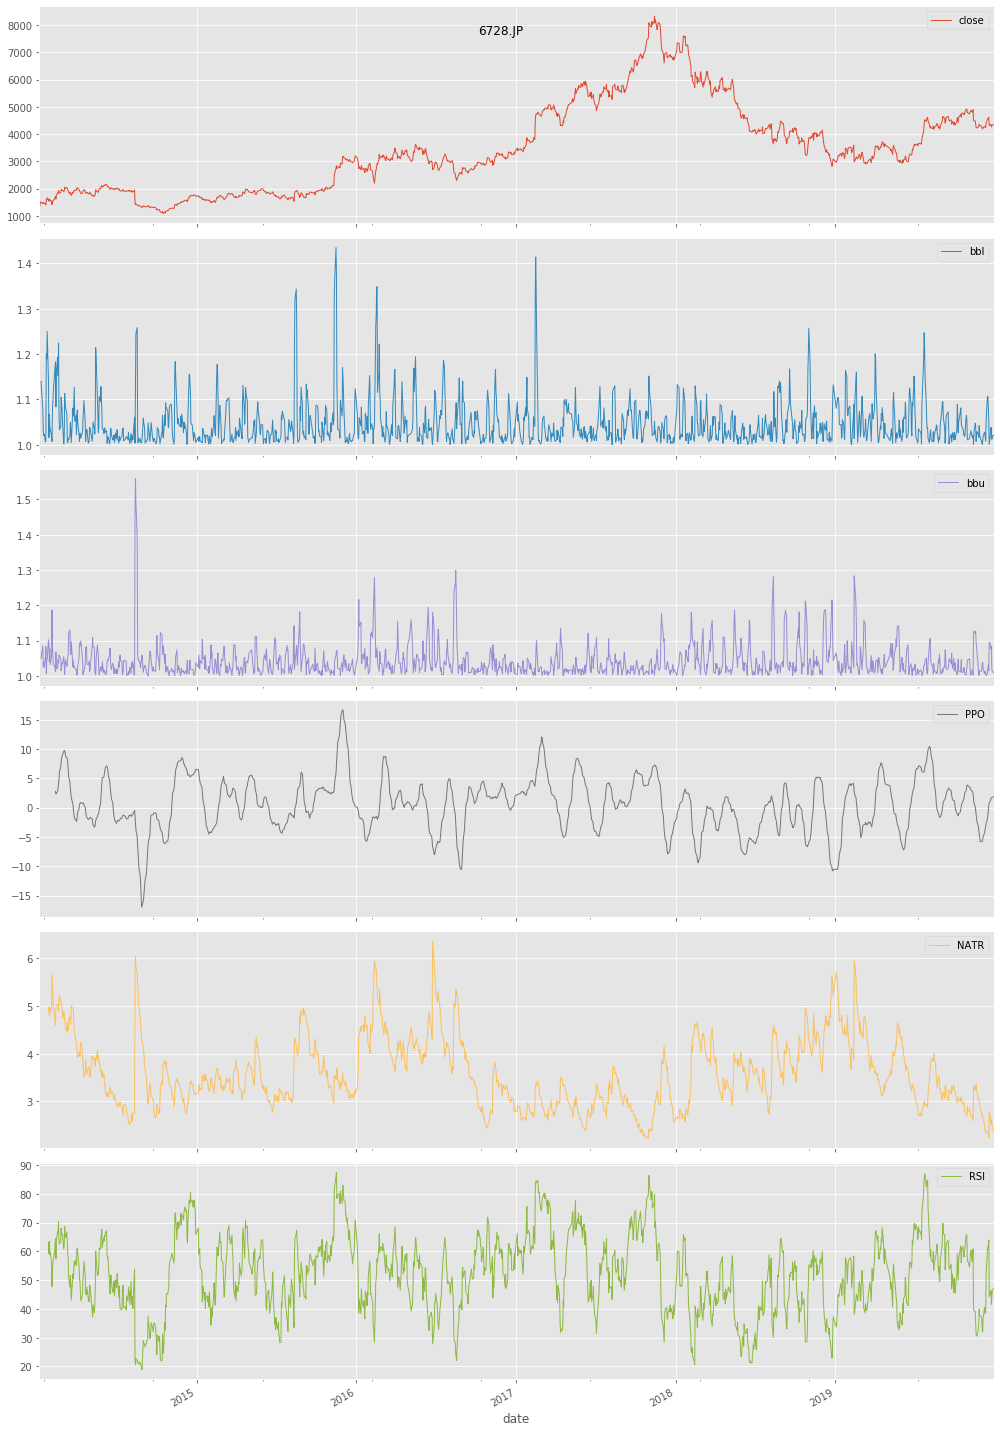

In [53]:
ticker = np.random.choice(data.index.get_level_values('symbol'))
(data.loc[idx[ticker, :], ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']].reset_index('symbol', drop=True)
 .plot(lw=1, subplots=True, figsize=(14, 20), title=ticker))
plt.tight_layout();

In [54]:
data = data.drop(prices.columns, axis=1)

In [55]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [56]:
with pd.HDFStore('data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/quandl/us/equities            frame        (shape->[171162,61])


In [57]:
outcomes = []
by_symbol = data.groupby('symbol')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_symbol[f'ret_{t}'].shift(-t)

In [58]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 23 columns):
ret_1              1377100 non-null float64
ret_rel_perc_1     1377100 non-null float64
ret_5              1373340 non-null float64
ret_rel_perc_5     1373340 non-null float64
ret_10             1368640 non-null float64
ret_rel_perc_10    1368640 non-null float64
ret_21             1358300 non-null float64
ret_rel_perc_21    1358300 non-null float64
ret_63             1318820 non-null float64
ret_rel_perc_63    1318820 non-null float64
PPO                1354540 non-null float64
NATR               1364880 non-null float64
RSI                1364880 non-null float64
bbl                1374280 non-null float64
bbu                1374280 non-null float64
weekday            1378040 non-null int64
month              1378040 non-null int64
year               1378040 non-null int64
fwd_ret_01         1377100 non-null float64
fwd_r

In [59]:
data.to_hdf('data.h5', 'stooq/japan/equities')

## Grouped TimePeriodSplit

In [20]:
class GroupedTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'"""

    def __init__(self, n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 shuffle=False):
        self.n_splits = n_splits
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        n = self.n_splits
        test = self.test_length
        train = self.train_length
        days = (sorted(X.index.get_level_values('date')
                        .unique(), reverse=True))

        split_idx = []
        for i in range(n):
            test_end_idx = i*self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx
            train_start_idx = train_end_idx + self.train_length
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start]) &
                              (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start]) &
                             (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Verify that it works

In [161]:
cv = GroupedTimeSeriesSplit(n_splits=60)

Check that train/test periods have the correct number of observations and start/end dates.

In [ ]:
for train_idx, test_idx in cv.split(X=data, y=data['fwd_ret_1']):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())

## Baseline: Linear Regression

In [21]:
data = pd.read_hdf('data.h5', 'stooq/japan/equities')
outcomes = data.filter(like='fwd').columns.tolist()

In [22]:
cv = GroupedTimeSeriesSplit(n_splits=36,
                            test_period_length=21,
                            train_period_length=2 * 252)

In [23]:
lr = LinearRegression()

In [24]:
lr_metrics = {}
for outcome in outcomes:
    cv_preds = []
    df = data.drop([c for c in outcomes if c != outcome], axis=1).dropna()
    X, y = df.drop(outcome, axis=1), df[outcome]
    dates = X.index.get_level_values('date')
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        cv_preds.append(y_test.to_frame('y_test').assign(y_pred=y_pred, i=i))
    cv_preds = pd.concat(cv_preds)
    corr, _ = spearmanr(cv_preds.y_test, cv_preds.y_pred)
    lr_metrics[outcome] = corr

10.13
10.69
9.52
9.79
9.65


In [25]:
lr_metrics = pd.Series(lr_metrics)
lr_metrics

fwd_ret_01    0.001529
fwd_ret_05    0.018831
fwd_ret_10    0.024157
fwd_ret_21    0.036449
fwd_ret_63    0.121134
dtype: float64

## LightGBM Random Forest Model

In [52]:
T = 1, 5, 10, 21, 63
with pd.HDFStore('baseline.h5') as store:
    predictions = pd.concat([store[f'fwd_ret_{t:02}/predictions'].assign(Outcome=t) for t in T])
    rf_metrics = store['metrics']

In [55]:
metrics = rf_metrics.set_index('outcome')['100'].to_frame('Random Forest').join(lr_metrics.to_frame('Linear Regression'))
metrics.index = metrics.index.to_series().str.split('_').str[-1].astype(int)
metrics.index.name = 'Outcome'
metrics

,Random Forest,Linear Regression
Outcome,,
1,0.006860,0.001529
5,0.083198,0.018831
10,0.065664,0.024157
21,0.086180,0.036449
63,0.225534,0.121134


In [56]:
ic = (predictions.groupby(['Outcome', 'i']).apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
      .to_frame('Information Coefficient')
      .reset_index())

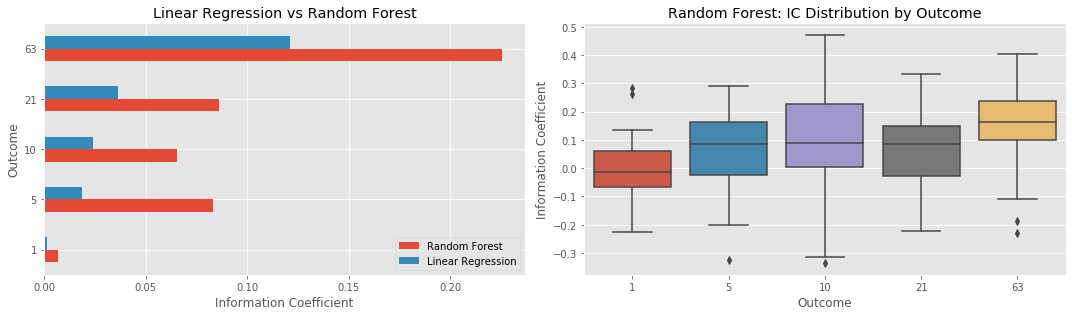

In [91]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4.5))
metrics.plot.barh(ax=ax1, title='Linear Regression vs Random Forest')
ax1.set_xlabel('Information Coefficient')
sns.boxplot(x='Outcome', y='Information Coefficient', data=ic, ax=ax2)
ax2.set_title('Random Forest: IC Distribution by Outcome')
fig.tight_layout()
fig.savefig('figures/ic_comp', dpi=300);

### Hyperparameter Tuning

In [ ]:
cv = GroupedTimeSeriesSplit(n_splits=36,
                            test_period_length=21,
                            train_period_length=2 * 252)

In [73]:
outcomes = data.filter(like='fwd').columns.tolist()
outcomes

['fwd_ret_01', 'fwd_ret_05', 'fwd_ret_10', 'fwd_ret_21', 'fwd_ret_63']

In [ ]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

In [81]:
bagging_fraction_opts = [.8, .95]
feature_fraction_opts = [.5, .6, .7, .8, .9]
min_data_in_leaf_opts = [500, 1000, 2000, 3000]

In [82]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
np.random.shuffle(cv_params)
len(cv_params)

40

In [ ]:
bagging_fraction_opts = [.8, .95]
feature_fraction_opts = [.5, .6, .7, .8, .9]
min_data_in_leaf_opts = [500, 1000, 2000, 3000]

In [ ]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
np.random.shuffle(cv_params)

In [ ]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

In [ ]:
num_iterations = list(range(25, 151, 25))
num_boost_round = num_iterations[-1]

In [83]:
categoricals = ['ticker', 'year', 'weekday', 'month']

In [ ]:
for outcome in outcomes:
    outcome_data = data.drop([c for c in outcomes if c != outcome], axis=1).dropna()
    lgb_data = lgb.Dataset(data=outcome_data.drop(outcome, axis=1),
                           label=outcome_data[outcome],
                           categorical_feature=categoricals,
                           free_raw_data=False)

    for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params):
        print(f'{p:3.0f} | {len(cv_params):4.0f}')
        params = base_params.copy()
        params.update(dict(bagging_fraction=bagging_fraction,
                           feature_fraction=feature_fraction,
                           min_data_in_leaf=min_data_in_leaf))

        start = time()
        cv_preds = []
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()
            lgb_test = lgb_data.subset(test_idx.tolist()).construct()

            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              # early_stopping_rounds=25,
                              # valid_sets=[lgb_test],
                              # valid_names=['eval'],
                              verbose_eval=-1)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, outcome]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                              feature_fraction=feature_fraction,
                                              min_data_in_leaf=min_data_in_leaf)
        corr = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        metrics.append([outcome, bagging_fraction, feature_fraction, min_data_in_leaf] + corr)
        t = time() - start
        msg = f'\n{p:3.0f} | {t:5,.1f} | {outcome.split("_")[-1]:3s} | '
        msg += f'{bagging_fraction:5.2f} | {feature_fraction:5.2f} | {min_data_in_leaf:3.0f} | '
        print(msg + ' | '.join([f'{c:6.2%}' for c in corr]))
        cols = ['outcome', 'bagging_fraction', 'feature_fraction', 'min_data_in_leaf'] + \
               [str(n) for n in num_iterations]
        predictions.append(cv_preds)
        if store.exists():
            store.unlink()
        pd.DataFrame(metrics, columns=cols).to_hdf(store, 'metrics')
        pd.concat(predictions).to_hdf(store, f'{outcome}/predictions')

### Analyse Results

In [93]:
params = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
num_iterations = [str(i) for i in range(25, 151, 25)]

In [94]:
def get_ic(x):
    return pd.Series({int(n): spearmanr(x.y_test, x[n])[0] for n in num_iterations})

In [101]:
with pd.HDFStore('results.h5') as store:
    predictions= store['fwd_ret_21/predictions']

In [102]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20608560 entries, (1332.JP, 2019-10-31 00:00:00) to (9989.JP, 2016-11-28 00:00:00)
Data columns (total 11 columns):
y_test              float64
25                  float64
50                  float64
75                  float64
100                 float64
125                 float64
150                 float64
i                   int64
bagging_fraction    float64
feature_fraction    float64
min_data_in_leaf    int64
dtypes: float64(9), int64(2)
memory usage: 1.8+ GB


In [103]:
predictions['period'] = (predictions.i>12).astype(int).map({1:'train', 0: 'test'})
predictions = predictions.drop('i', axis=1)

#### Compute Information Coefficient

In [104]:
predictions.groupby(params).apply(get_ic).max(1).sort_values(ascending=False).head().to_frame('Information Coefficient').reset_index().to_csv('cv_result')

In [90]:
predictions.reset_index().groupby('period').date.describe()

,count,unique,top,freq,first,last
period,,,,,,
test,7441980,273,2019-07-12,27260,2018-10-15,2019-11-29
train,13166580,483,2018-02-16,27260,2016-10-27,2018-10-12


#### Select best CV result for train period

In [106]:
ic.idxmax(1).unstack('period').apply(lambda x: x.value_counts()).loc[:, ['train', 'test']]

period,train,test
25,NaN,6
50,2.0,7
100,27.0,13
125,NaN,3


In [105]:
ic = predictions.groupby(params + ['period']).apply(get_ic)

In [107]:
ic.head()

25        50   \
bagging_fraction feature_fraction min_data_in_leaf period                       
0.8              0.5              500              test   -0.126852 -0.104760   
                                                   train   0.138512  0.155384   
                                  1000             test   -0.127076 -0.105815   
                                                   train   0.134380  0.152566   
                                  2000             test   -0.128568 -0.109261   

                                                                75        100  \
bagging_fraction feature_fraction min_data_in_leaf period                       
0.8              0.5              500              test   -0.097828 -0.095892   
                                                   train   0.158777  0.161853   
                                  1000             test   -0.100248 -0.098285   
                                                   train   0.155953  0.159749   
                                  2000             test   -0.102143 -0.100416   

                                                                125       150  
bagging_fraction feature_fraction min_data_in_leaf period                      
0.8              0.5              500              test   -0.096106 -0.097615  
                                                   train   0.157176  0.156589  
                                  1000             test   -0.098146 -0.099560  
                                                   train   0.154519  0.153883  
                                  2000             test   -0.099643 -0.100708

In [110]:
ic[100].unstack('period')['train'].sort_values(ascending=False).head().to_frame('Information Coefficient').reset_index().to_csv('cv_result.csv')

In [29]:
bagging_fraction, feature_fraction, min_data_in_leaf, _ = ic.loc[idx[:, :, :, 'train'], 100].idxmax()

In [35]:
best_preds = (predictions.loc[(predictions.bagging_fraction==bagging_fraction) &  
                             (predictions.feature_fraction==feature_fraction) & 
                             (predictions.min_data_in_leaf == min_data_in_leaf), ['100', 'train']]
             .rename(columns={'100': 'predictions'}))                             

In [36]:
best_preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 710640 entries, (1332.JP, 2019-10-31 00:00:00) to (9989.JP, 2016-11-28 00:00:00)
Data columns (total 2 columns):
predictions    710640 non-null float64
train          710640 non-null object
dtypes: float64(1), object(1)
memory usage: 13.6+ MB


In [65]:
best_preds.to_hdf('predictions.h5', 'data', format='t')

### Generate predictions

In [ ]:
predictions, metrics = [], []
cat_feats = ['ticker', 'year', 'weekday', 'month']

outcome = 'fwd_ret_05'
outcome_data = data.drop(
    [c for c in outcomes if c != outcome], axis=1).dropna()

lgb_data = lgb.Dataset(data=outcome_data.drop(outcome, axis=1),
                       label=outcome_data[outcome],
                       categorical_feature=cat_feats,
                       free_raw_data=False)

bagging_fraction = .95
feature_fraction = .6
min_data_in_leaf = 2000

params = dict(boosting_type='rf',
              objective='regression',
              bagging_freq=1,
              bagging_fraction=bagging_fraction,
              feature_fraction=feature_fraction,
              min_data_in_leaf=min_data_in_leaf,
              verbose=-1)


cv_preds = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()

    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=100,
                      verbose_eval=-1)

    test_set = outcome_data.iloc[test_idx, :]
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, outcome]
    y_pred = model.predict(X_test)

    cv_preds.append(y_test.to_frame('y_test').assign(y_pred=y_pred, i=i))

predictions = pd.concat(cv_preds)
predictions.to_hdf('predictions.h5', 'data')

In [168]:
num_iterations = list(range(25, 151, 25))
def get_ic(x):
#     print(x.info())
    return pd.Series({n: spearmanr(x.y_test, x[str(n)])[0] for n in num_iterations})

In [219]:
with pd.HDFStore('results_21.h5') as store:
    print(store.info())
    df = store['preds']
    preds = df['100'].to_frame('predictions')
    store.put('predictions', preds)
#     preds

# df.info()
df.groupby('i').apply(get_ic).iloc[:24].mean()

<class 'pandas.io.pytables.HDFStore'>
File path: results_21.h5
/experiment_1            series       (shape->[1])       
/preds                   frame        (shape->[710640,8])


25     0.058286
50     0.063368
75     0.063964
100    0.065804
125    0.062425
150    0.062856
dtype: float64

## AlphaLens Analysis

### Prepare Data

Using next available prices.

In [61]:
trade_prices = prices.open.unstack('symbol').shift(-1).tz_localize('UTC').loc[:'2019']
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1466 entries, 2014-01-06 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Columns: 940 entries, 1332.JP to 9989.JP
dtypes: float64(940)
memory usage: 10.5 MB


In [62]:
dollar_vol = prices.close.mul(prices.volume)
factor_groups = pd.qcut(dollar_vol.groupby(level='symbol').mean(), q=5, labels=False)
factor_groups.head()

symbol
1332.JP    3
1377.JP    1
1379.JP    0
1407.JP    0
1414.JP    1
dtype: int64

In [66]:
predictions = (pd.read_hdf('baseline.h5', 'fwd_ret_21/predictions')
                  .rename(columns={'y_pred': 'predictions'}))

factor = predictions.predictions.tz_localize('UTC', level='date').swaplevel().dropna()
factor.head()

date                       symbol 
2019-10-31 00:00:00+00:00  1332.JP    0.013732
2019-11-01 00:00:00+00:00  1332.JP   -0.037957
2019-11-05 00:00:00+00:00  1332.JP   -0.032704
2019-11-06 00:00:00+00:00  1332.JP   -0.032357
2019-11-07 00:00:00+00:00  1332.JP   -0.032357
Name: predictions, dtype: float64

In [67]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   groupby=factor_groups.to_dict(),
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21),
                                                   zero_aware=True,
                                                   max_loss=.9,
                                                   filter_zscore=None)

Dropped 10.8% entries from factor data: 0.0% in forward returns computation and 10.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!


### Compare Spread by Outcome

Dropped 50.4% entries from factor data: 2.6% in forward returns computation and 47.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 34.1% entries from factor data: 2.1% in forward returns computation and 32.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 29.0% entries from factor data: 1.5% in forward returns computation and 27.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 10.8% entries from factor data: 0.0% in forward returns computation and 10.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!


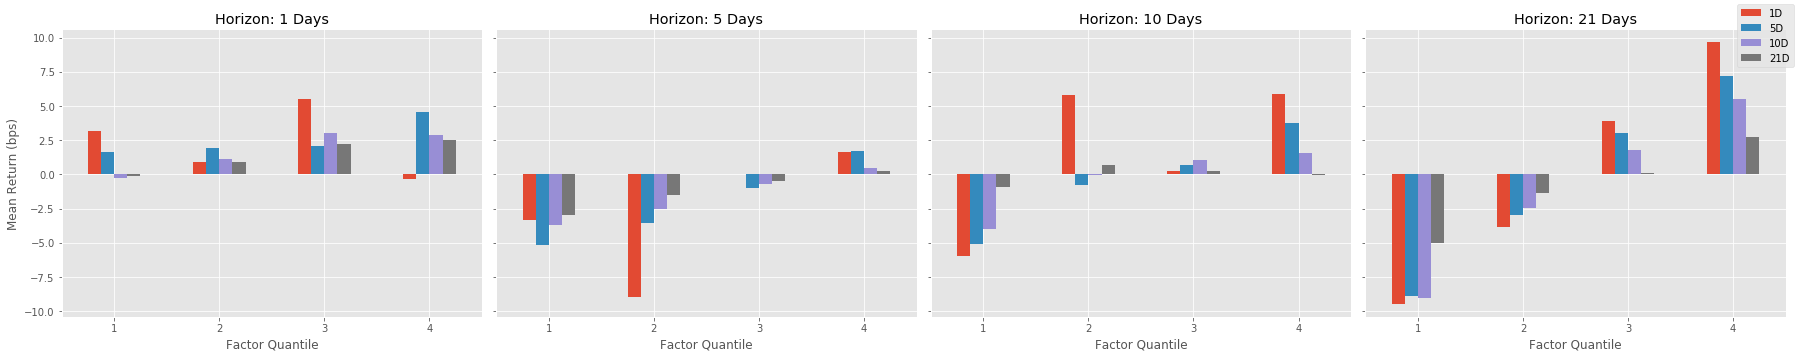

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5), sharey='row', sharex=True)
axes = axes.flatten()
for i, t in enumerate([1, 5, 10, 21]):
    df = (pd.read_hdf('baseline.h5', f'fwd_ret_{t:02}/predictions')
          .rename(columns={'y_pred': 'predictions'}))
    factor = df.predictions.tz_localize(
        'UTC', level='date').swaplevel().dropna()
    factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                       prices=trade_prices,
                                                       groupby=factor_groups.to_dict(),
                                                       quantiles=5,
                                                       periods=(1, 5, 10, 21),
                                                       zero_aware=True,
                                                       max_loss=.9,
                                                       filter_zscore=None)
    mean_quant_ret, std_quantile = mean_return_by_quantile(factor_data,
                                                           by_group=False,
                                                           demeaned=True,
                                                           group_adjust=False)
    mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                              base_period=mean_quant_ret.columns[0])
    mean_quant_rateret.index.name = 'Factor Quantile'
    mean_quant_rateret.index = mean_quant_rateret.index.astype(int)

    axes[i].set_title(f'Horizon: {t} Days')
    mean_quant_rateret.index.name = 'Factor Quantile'
    mean_quant_rateret.index = mean_quant_rateret.index.astype(int)
    (mean_quant_rateret * 10000).plot.bar(rot=0, title=f'Horizon: {t} Days', ax=axes[i])
    axes[i].set_ylabel('Mean Return (bps)')

handles, labels = axes[i].get_legend_handles_labels()
for ax in axes:
    ax.get_legend().remove()
fig.legend(handles, labels, loc='best')
fig.tight_layout()
fig.savefig('figures/alphalens', dpi=300);

### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-1.428776e-01,-4.437774e-04,-0.025056,0.017232,157413,24.845792
2.0,-6.026316e-02,-4.239851e-08,-0.014277,0.013239,153284,24.194078
3.0,5.112095e-08,5.690760e-02,0.013573,0.010552,162230,25.606099
4.0,7.106573e-04,1.283947e-01,0.027935,0.017304,160633,25.354031


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.237,0.207,0.158,0.077
beta,0.061,-0.016,-0.026,-0.104
Mean Period Wise Return Top Quantile (bps),9.641,7.224,5.478,2.719
Mean Period Wise Return Bottom Quantile (bps),-9.459,-8.869,-9.054,-5.015
Mean Period Wise Spread (bps),19.100,16.158,14.810,7.977


Information Analysis


,1D,5D,10D,21D
IC Mean,0.026,0.051,0.053,0.033
IC Std.,0.114,0.139,0.151,0.137
Risk-Adjusted IC,0.231,0.369,0.354,0.239
t-stat(IC),5.987,9.581,9.183,6.193
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.365,-0.157,-0.160,-0.137
IC Kurtosis,0.489,0.199,0.354,0.794


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.487,0.166,0.619,0.376
Quantile 2 Mean Turnover,0.632,0.256,0.763,0.505
Quantile 3 Mean Turnover,0.598,0.213,0.743,0.440
Quantile 4 Mean Turnover,0.411,0.126,0.565,0.284


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.888,0.676,0.513,0.308


<Figure size 432x288 with 0 Axes>

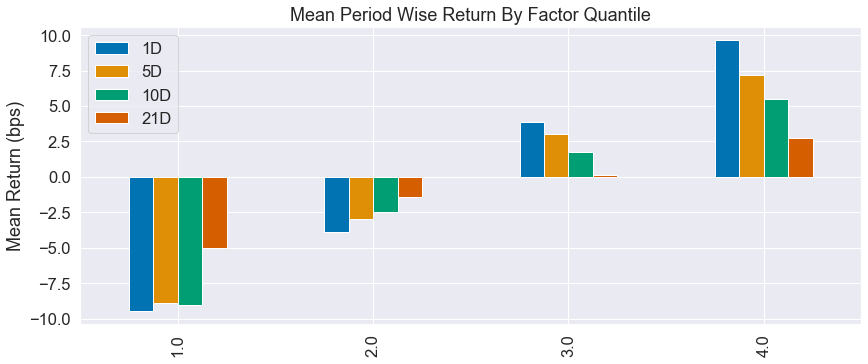

In [68]:
create_summary_tear_sheet(factor_data)

### Full Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-7.364480e-02,-1.821272e-04,-0.013558,0.009476,44824,14.108020
2.0,-3.361191e-02,-1.958717e-07,-0.006758,0.008058,44655,14.054828
3.0,1.642178e-07,2.499788e-02,0.006318,0.004277,114215,35.948319
4.0,1.759391e-03,7.976588e-02,0.015692,0.008603,114026,35.888833


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.241,0.193,0.137,0.068
beta,0.143,0.082,0.058,-0.025
Mean Period Wise Return Top Quantile (bps),9.518,8.070,5.692,2.900
Mean Period Wise Return Bottom Quantile (bps),-6.946,-4.596,-2.896,-1.207
Mean Period Wise Spread (bps),16.464,12.781,8.860,4.483


<Figure size 432x288 with 0 Axes>

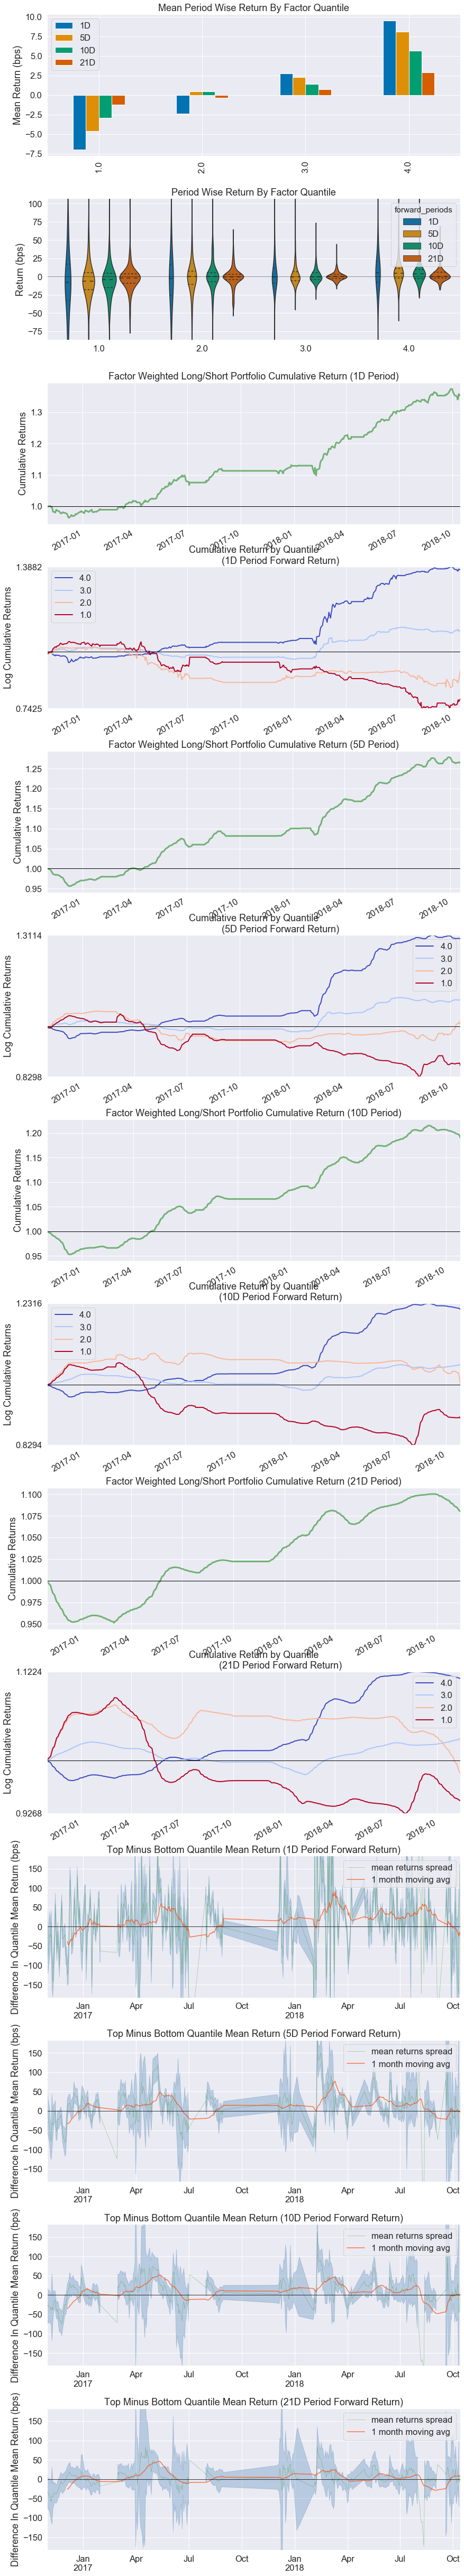

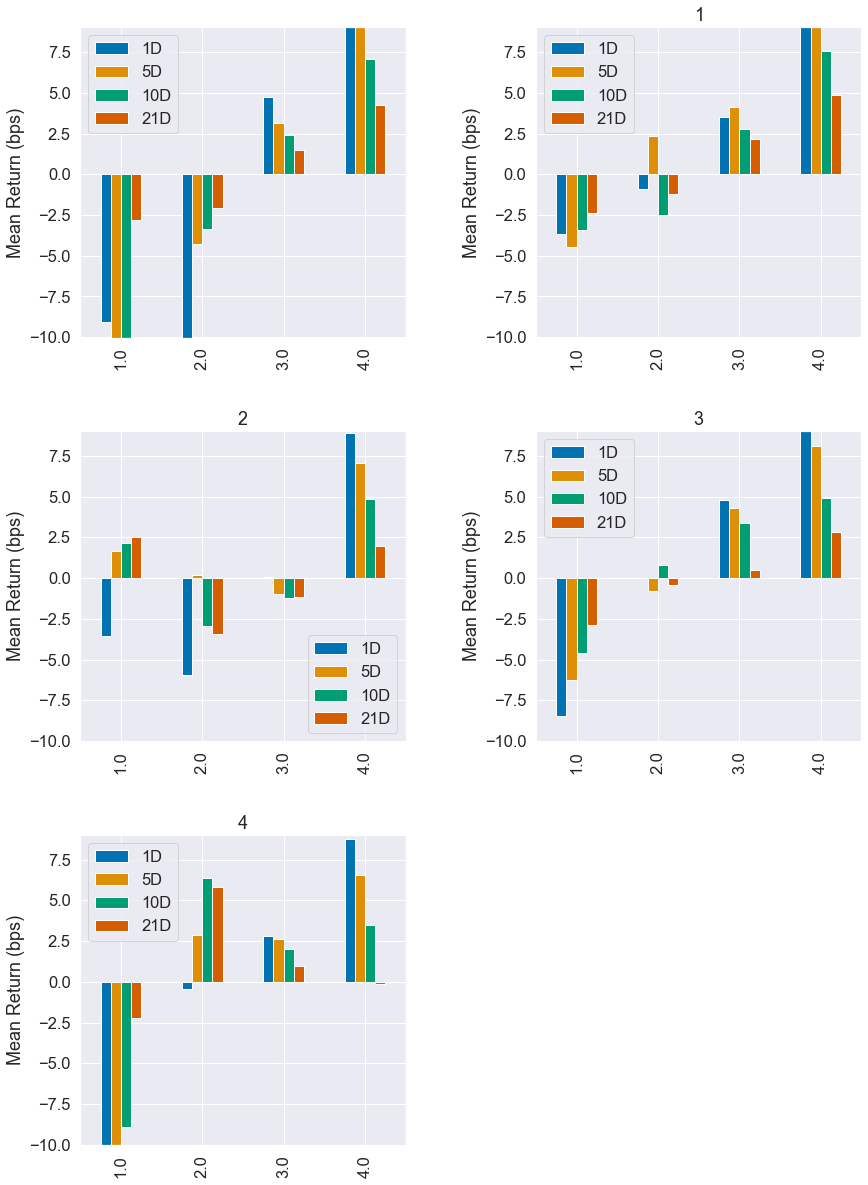

Information Analysis


,1D,5D,10D,21D
IC Mean,0.027,0.052,0.046,0.021
IC Std.,0.124,0.150,0.166,0.143
Risk-Adjusted IC,0.221,0.347,0.278,0.146
t-stat(IC),4.064,6.381,5.108,2.687
p-value(IC),0.000,0.000,0.000,0.008
IC Skew,-0.446,-0.390,-0.306,-0.033
IC Kurtosis,0.403,0.479,0.451,0.204


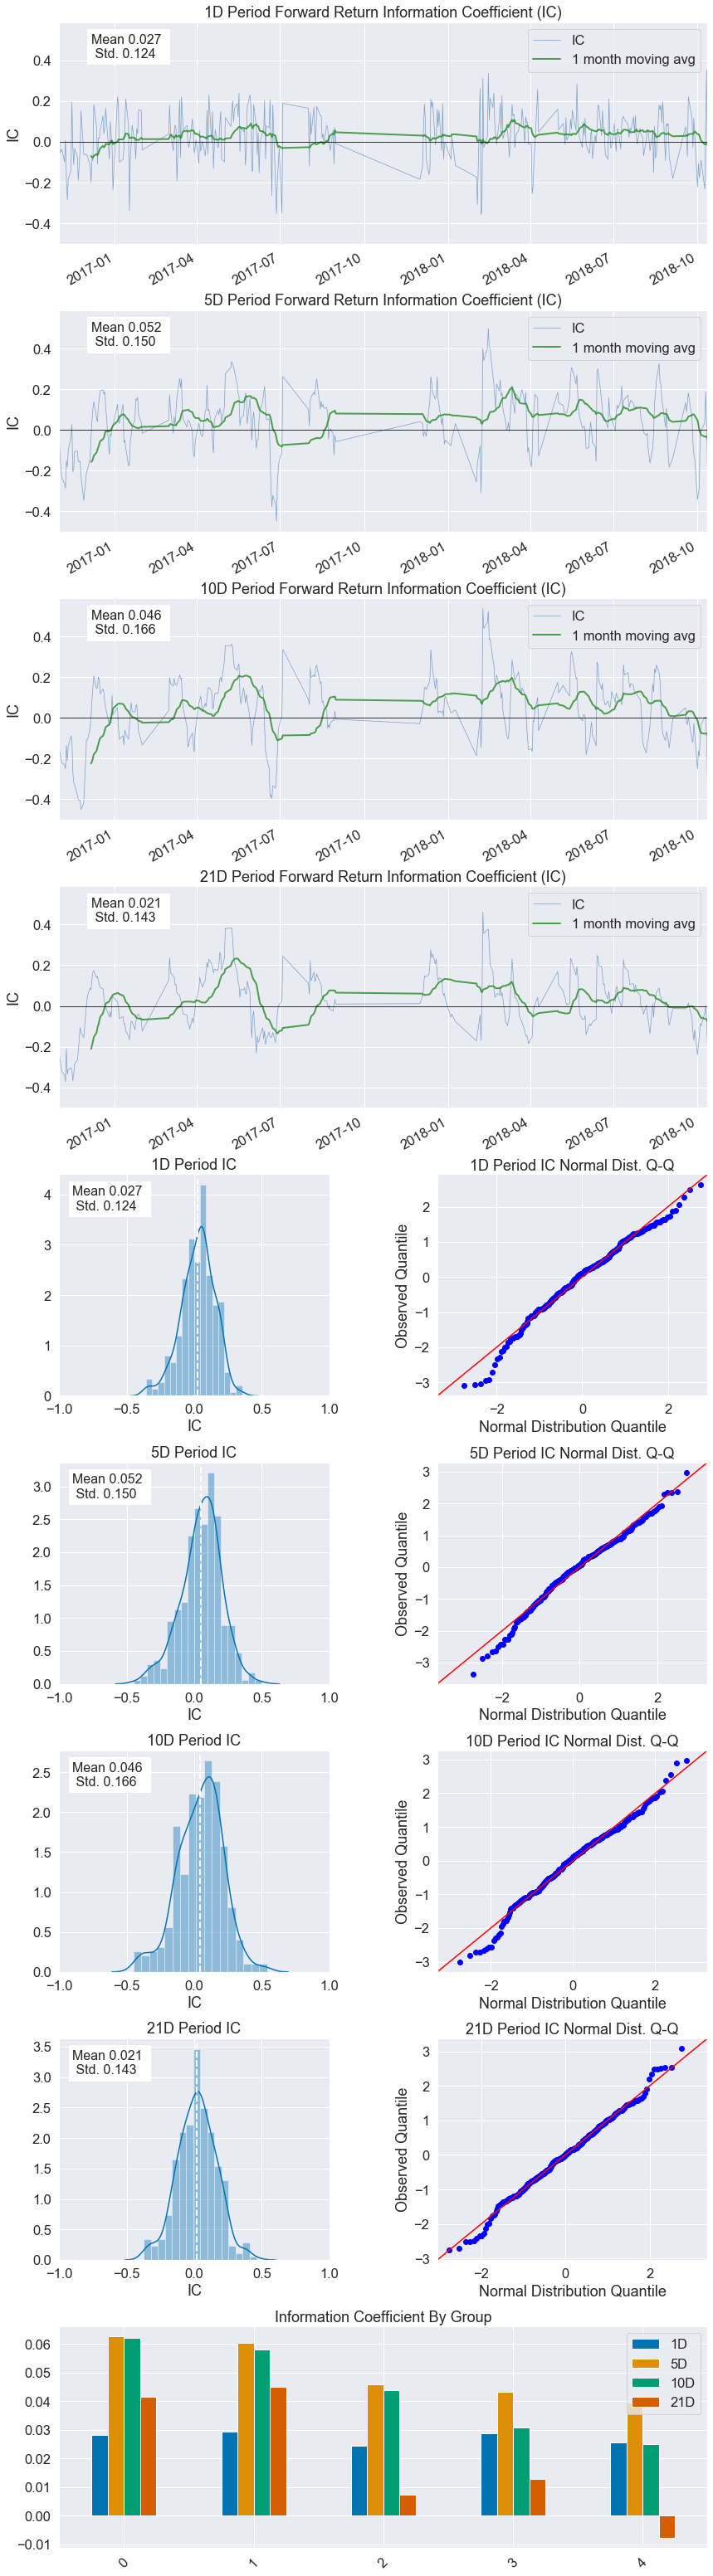

Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.544,0.234,0.621,0.443
Quantile 2 Mean Turnover,0.765,0.457,0.841,0.680
Quantile 3 Mean Turnover,0.537,0.245,0.661,0.428
Quantile 4 Mean Turnover,0.374,0.144,0.508,0.277


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.898,0.723,0.596,0.42


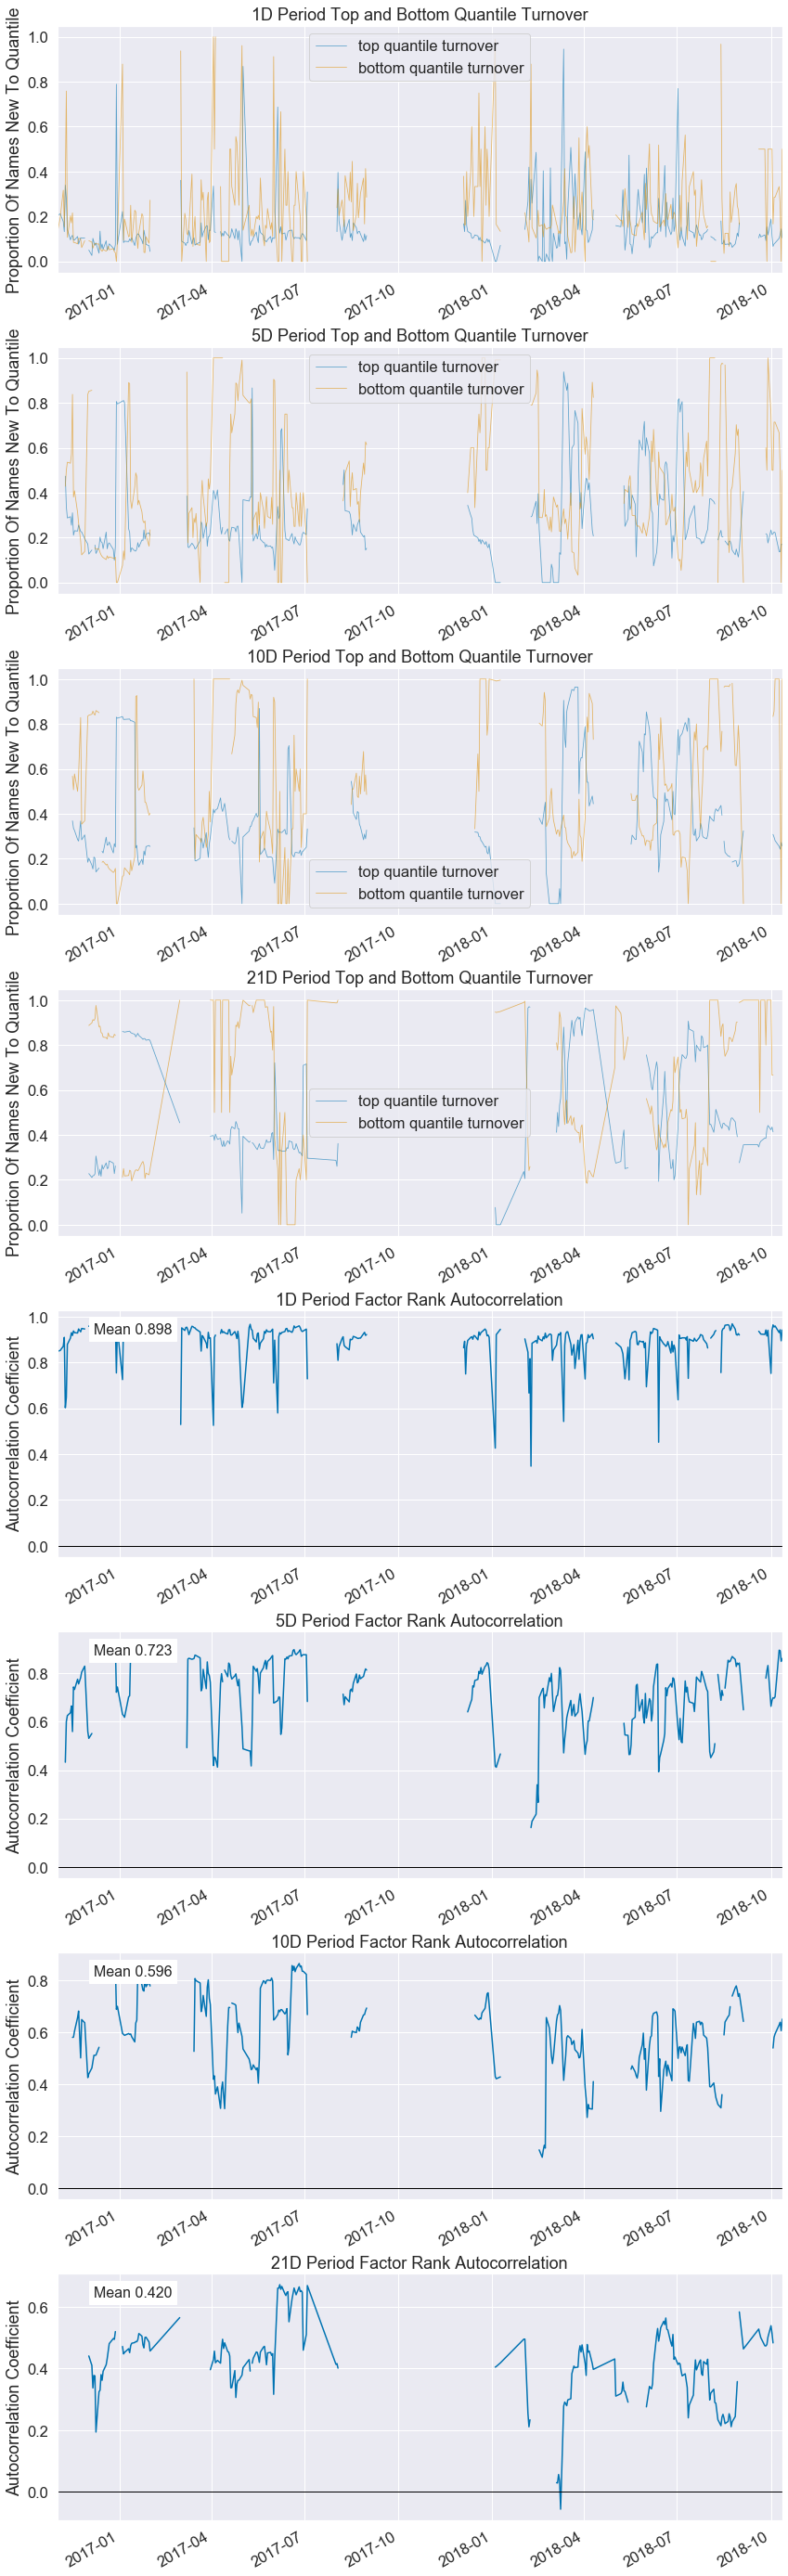

In [101]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)